In [3]:
import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy,
    construct_features_sbert_embeddings,
)

from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_split_flatten_masked,
)

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)

import joblib
from pprint import pprint
import numpy as np

from pathlib import Path





In [ ]:
motion_new_path = "/tank/shared/2024/visual/AOT/temp/motion_freq_test[0,2,4,8,16,32]"
#read all teh np file and check shape
#also print file size
motion_new_path = Path(motion_new_path)
motion_new_files = motion_new_path.glob("*.npy")
motion_new_files = sorted(motion_new_files)
motion_new_file_list = []





#check whether all the files are complete
for motion_new_file in motion_new_files:
    motion_new_file_list.append(motion_new_file)
    motion_new_data = np.load(motion_new_file)
    print(f"File: {motion_new_file.name}, shape: {motion_new_data.shape}, size: {motion_new_data.nbytes/1024/1024} MB")


File: 0001_fw.mp4.npy, shape: (60, 11845), size: 2.7111053466796875 MB
File: 0002_fw.mp4.npy, shape: (61, 11845), size: 2.7562904357910156 MB
File: 0003_fw.mp4.npy, shape: (60, 11845), size: 2.7111053466796875 MB
File: 0004_fw.mp4.npy, shape: (61, 11845), size: 2.7562904357910156 MB
File: 0005_fw.mp4.npy, shape: (61, 11845), size: 2.7562904357910156 MB
File: 0006_fw.mp4.npy, shape: (61, 11845), size: 2.7562904357910156 MB
File: 0007_fw.mp4.npy, shape: (61, 11845), size: 2.7562904357910156 MB
File: 0008_fw.mp4.npy, shape: (61, 11845), size: 2.7562904357910156 MB
File: 0009_fw.mp4.npy, shape: (61, 11845), size: 2.7562904357910156 MB
File: 0010_fw.mp4.npy, shape: (60, 11845), size: 2.7111053466796875 MB
File: 0011_fw.mp4.npy, shape: (61, 11845), size: 2.7562904357910156 MB
File: 0012_fw.mp4.npy, shape: (60, 11845), size: 2.7111053466796875 MB
File: 0013_fw.mp4.npy, shape: (60, 11845), size: 2.7111053466796875 MB
File: 0014_fw.mp4.npy, shape: (60, 11845), size: 2.7111053466796875 MB
File: 

In [ ]:
motion_old_path = (
    "/tank/shared/2024/visual/AOT/temp/motion_energy_features/video_features"
)

# with old default spatial frequency[0,2,4,8,16]
#read all teh np file and check shape
#also print file size
motion_old_path = Path(motion_old_path)
motion_old_files = motion_old_path.glob("*.npy")
motion_old_files = sorted(motion_old_files)
motion_old_file_list = []
#check whether all the files are complete
for motion_old_file in motion_old_files:
    motion_old_file_list.append(motion_old_file)
    motion_old_data = np.load(motion_old_file)
    print(f"File: {motion_old_file.name}, shape: {motion_old_data.shape}, size: {motion_old_data.nbytes/1024/1024} MB")

File: 0001_fw.npy, shape: (60, 2162), size: 0.494842529296875 MB
File: 0001_rv.npy, shape: (60, 2162), size: 0.494842529296875 MB
File: 0002_fw.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0002_rv.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0003_fw.npy, shape: (60, 2162), size: 0.494842529296875 MB
File: 0003_rv.npy, shape: (60, 2162), size: 0.494842529296875 MB
File: 0004_fw.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0004_rv.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0005_fw.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0005_rv.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0006_fw.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0006_rv.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0007_fw.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0007_rv.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0008_fw.npy, shape: (61, 2162), size: 0.5030899047851562 MB
File: 0008_rv.

In [21]:
from moten import (
    pyramids,
    utils,
    core,
    viz,
    io,
)
import moten

sample_video_file = (
    "/tank/shared/2024/visual/AOT/derivatives/stimuli/rescaled_final/0001_fw.mp4"
)

luminance_images = moten.io.video2luminance(sample_video_file)
spatial_frequencies = [0, 2, 4, 8, 16, 32]

# Create a pyramid of spatio-temporal gabor filters
nimages, vdim, hdim = luminance_images.shape
print(nimages, vdim, hdim)
pyramid = moten.get_default_pyramid(
    vhsize=(vdim, hdim), fps=24, spatial_frequencies=spatial_frequencies
)

moten.io.video2luminance: 60it [00:19,  3.13it/s]


60 1080 1920


<moten.pyramids.MotionEnergyPyramid [#11845 filters (ntfq=3, nsfq=6, ndirs=8) aspect=1.778]>
dict_keys(['centerh', 'centerv', 'direction', 'spatial_freq', 'spatial_env', 'temporal_freq', 'temporal_env', 'filter_temporal_width', 'aspect_ratio', 'stimulus_fps', 'spatial_phase_offset'])
len of spatial freqs: 11845
array([ 2.,  0.,  2., ..., 32., 32., 32.])


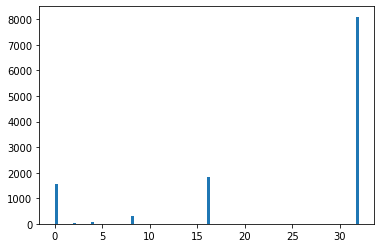

In [27]:
import matplotlib.pyplot as plt

print(pyramid)

# size_list = pyramid.get_filter_pixel_sizes()
# print(len(size_list))

print(pyramid.parameters.keys())

spatial_freq = pyramid.parameters["spatial_freq"]
plt.hist(spatial_freq, bins=100)

print("len of spatial freqs:",len(spatial_freq))
pprint(spatial_freq)

len of temporal freq: 11845
array([0., 0., 2., ..., 4., 2., 4.])


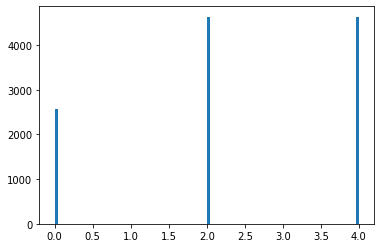

In [28]:
temporal_freq = pyramid.parameters["temporal_freq"]
plt.hist(temporal_freq, bins=100)

print("len of temporal freq:",len(temporal_freq))
pprint(temporal_freq)

11330


/tmp/ipykernel_181883/1516715193.py:2: RuntimeWarning: invalid value encountered in scalar divide
  v = temporal_freq / spatial_freq
/tmp/ipykernel_181883/1516715193.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  v = temporal_freq / spatial_freq


(array([3090.,    0.,    0., 3240.,    0.,    0., 3968.,    0.,    0.,
           0.,    0.,    0.,  848.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  144.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   32.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           8.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58

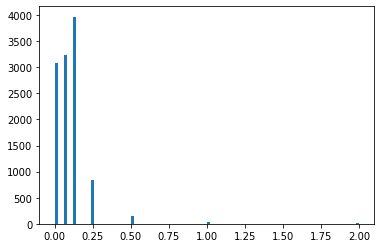

In [29]:
def velocity(spatial_freq, temporal_freq):
    v = temporal_freq / spatial_freq
    return v


def velovity_from_index(index):
    spatial_freq = pyramid.parameters["spatial_freq"][index]
    temporal_freq = pyramid.parameters["temporal_freq"][index]
    return velocity(spatial_freq, temporal_freq)


velocity_list = []
for i in range(11845):
    spatial_freq = pyramid.parameters["spatial_freq"][i]
    temporal_freq = pyramid.parameters["temporal_freq"][i]
    velocity_list.append(velocity(spatial_freq, temporal_freq))

# if inf replace with 0
velocity_list = np.array(velocity_list)
velocity_list[np.isinf(velocity_list)] = 0
# remove nan
velocity_list = velocity_list[~np.isnan(velocity_list)]
pprint(len(velocity_list))


plt.hist(velocity_list, bins=100)

In [30]:

# stimaccess = StimuliInfoAccess()
# stimuli = stimaccess._temp_read_motion_energy_features

# # from 1 to 2179, regular list
# video_indexs = [i for i in range(1, 2179)]


